# TWW 

**Tanzania Water Wells** quality classification.

In [1]:
# Basic Libs
import pandas as pd
import numpy as np

# DataViz Libs
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

# Notebook Setup
from warnings import simplefilter
simplefilter('ignore')
pd.set_option('display.max_columns', None)

## Loading Datasets

In [2]:
# Load Datasets
X = pd.read_csv('../data/X_train.csv')
y = pd.read_csv('../data/y_train.csv')

In [3]:
# Meet the dataset
X.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


### Checks

**Train and test datasets have been provided separately.**

Let's see if they satisfy some conditions.

The conditions are:

- **Both datasets have the same number of rows;**
- **Both datasets are _sorted_ equally in order or appearance;**

If these conditions are not met, we will need some basic data wrangling before proceeding.

#### Number of Rows

In [4]:
# Check if the number of rows in both X and y are the same
X.shape, y.shape

((59400, 40), (59400, 2))

Both datasets have the same number of rows, which is a good sign.

Now we can investigate the second condition, about their order of appearance.

#### Equally sorted

In [5]:
(X['id'].values == y['id'].values).all()

True

In [6]:
print(y['id'].values[:5])
print(X['id'].values[:5])

[69572  8776 34310 67743 19728]
[69572  8776 34310 67743 19728]


`X` and `y` are _sorted_ equally. The second condition has also been met.

The integrity of the datasets have been confirmed.

At the moment of training a classification model for the task we will use them separately, but there are still some **Exploratory Data Analysis (EDA)** ahead. If we keep them separate and drop some rows in `X` dataset, for example, we will need to perform the same operation for the corresponding indexes in `y`. 

It's more convenient to merge both datasets into a simple `df` python variable.

### Merge `X` and `y` into `df`

In [7]:
# Merge X and y
df = X.merge(y, on = 'id')
df.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional


## EDA

**Exploratory Data Analysis is an extended task for Modeling Data**. 

Let's do some EDA on data integrity rather than statistical significance for now.

### Shape

In [8]:
# Check df shape
df.shape

(59400, 41)

### Metadata

In [9]:
# Check df metadata
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

One of the easiest things to notice in this dataset is that:

1. `date_recorded` variable is stored as a `pandas` `object` instead of `datetime` object. We will handle this shortly;
2. Some variables have `null` values;

Other data types issues, harder to spot, may refer to `bool` variables recorded as object. We will investigate on that either.

But first, it's convenient to keep track of what needs to be done in a TO-DO list. Let's build it.

</br><center>------</center></br>

As of now, our TO-DO list looks like this:

**TO-DO**
- [ ] parse `date_recorded` to `pd.datetime` data type;
- [ ] investigate on possible wrongly parsed data types for `object` variables;
- [ ] deal with `null` values.


#### Handling `date_recorded` variable data type

In [10]:
# Change date_recorded to datetime dtype
df['date_recorded'] = pd.to_datetime(df['date_recorded'])

#### Investigate other data types

In [11]:
categorical_vars = X.select_dtypes(include = 'object', exclude = 'datetime64').columns.tolist()

for var in categorical_vars:
    if len(X[var].value_counts()) <= 2:
        print(var.center(34, '-'))
        print(X[var].value_counts(dropna = False), '\n')
        print(f'Percent (%) of NaNs: {(X[var].isna().mean())*100:.2f}%'.center(34))
        print("-".center(34, '-'), '\n')
        

----------public_meeting----------
True     51011
False     5055
NaN       3334
Name: public_meeting, dtype: int64 

    Percent (%) of NaNs: 5.61%    
---------------------------------- 

-----------recorded_by------------
GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64 

    Percent (%) of NaNs: 0.00%    
---------------------------------- 

--------------permit--------------
True     38852
False    17492
NaN       3056
Name: permit, dtype: int64 

    Percent (%) of NaNs: 5.14%    
---------------------------------- 



`public_meeting` and `permit` would have been parsed as `bool` if it wasn't for the `nan` values. We will deal with that when dealing with NAs values shortly.

`recorded_by` has a single value across all dataset. This variable is redundant and would add extra complexity to the model that would not result in a model's performance improvement. Let's drop it.

Before. Let's update our TO-DO list.

</br><center>------</center></br>

Updated TO-DO list:

**TO-DO**
- [x] [parse `date_recorded` to `pd.datetime` data type;](#Handling-date_recorded-variable-data-type)
- [ ] investigate on possible wrongly parsed data types for `object` variables;
    - [x] [review `df` and eyespot wrongly parsed datatypes;](#Loading-Datasets)
    - [ ] drop `recorded_by` due to redundancy;
    - [ ] check `category` variables unique number of classes;
- [ ] deal with `null` values.


### Drop `recorded_by`

In [12]:
df = df.drop(columns=['recorded_by'])

Updated TO-DO list:

**TO-DO**
- [x] [parse `date_recorded` to `pd.datetime` data type;](#Handling-date_recorded-variable-data-type)
- [ ] investigate on possible wrongly parsed data types for `object` variables;
    - [x] [review `df` and eyespot wrongly parsed datatypes;](#Loading-Datasets)
    - [x] [drop `recorded_by` due to redundancy;](#Drop-recorded_by)
    - [ ] check `category` variables unique number of classes;
- [ ] deal with `null` values.


### Check `category` variables

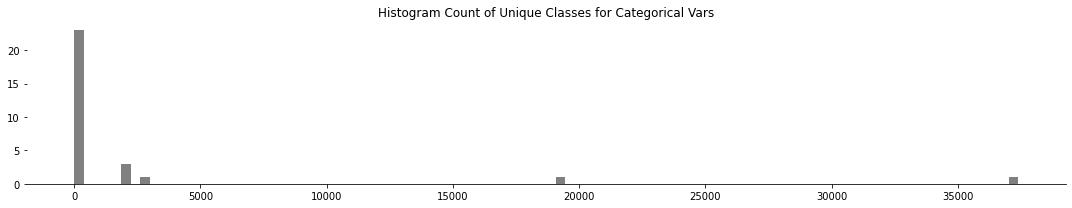

In [13]:
categorical_vars = df.select_dtypes(include=[object, 'category']).columns.tolist()

plt.figure(figsize=(15, 3))
df[categorical_vars].nunique().hist(color = 'gray', bins = 100)
sns.despine(left = True)
plt.title('Histogram Count of Unique Classes for Categorical Vars')
plt.grid()
plt.tight_layout()

Most variables have few unique classes. But some of them have more than 2000 classes. Some variable have around 20,000 unique classes or more.

Modeling with that amount of classes will be difficult. Let's investigate on those variables a little closer.

In [14]:
df[categorical_vars].nunique()[(df[categorical_vars].nunique() > 30)]

funder          1897
installer       2145
wpt_name       37400
subvillage     19287
lga              125
ward            2092
scheme_name     2696
dtype: int64

In [15]:
y['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

### NAs

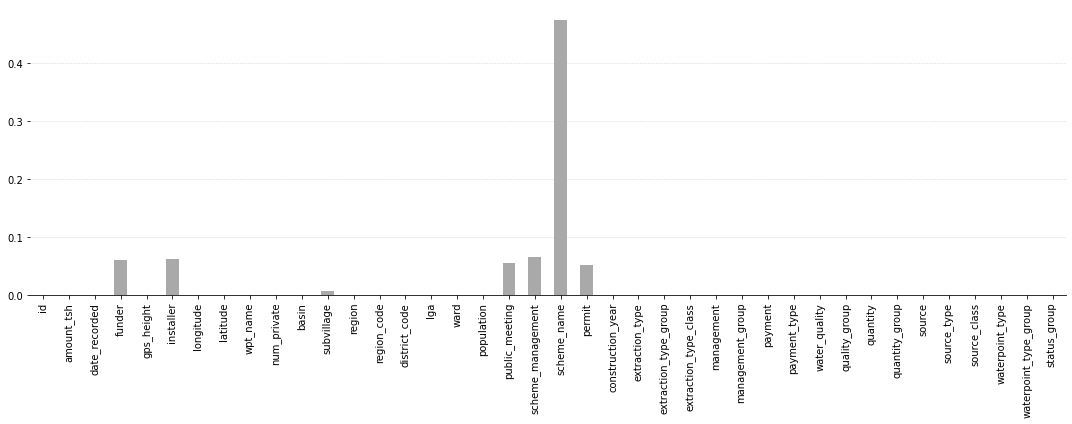

In [16]:
# Check null values
plt.figure(figsize = (15, 6))
df.isna().mean().plot(kind='bar', color = 'darkgray', zorder = 2)
sns.despine(left = True)
plt.grid(which = 'major', axis = 'y', color='lightgray', linestyle='--', linewidth=.5, zorder = 1)
plt.tight_layout()

Both **`public_meeting`** and **`permit`** variables appear as `categorical` data type, but they actually are `bool`. In fact, if it wasn't for the `'NaN'` values, they would have been parsed correctly yet while reading the file.

We need to either drop those lines or impute a thoughtful value. We'll consider this task ahead, but first let's take note of our tasks on helpful a **TO-DO list**.


</br><center>------</center></br>

**TO-DO**
- [x] parse `date_recorded` to `pd.datetime` data type
- [ ] drop or impute values to `public_meeting` and `permit`variables;
- [ ] drop `schema_name` variable;
- [ ] remove `recorded_by` columns due to that all values are the same `GeoDataConsultants Ltd`.


In [17]:
df = df.dropna(subset = ['public_meeting', 'permit'])
df.shape

(53281, 40)

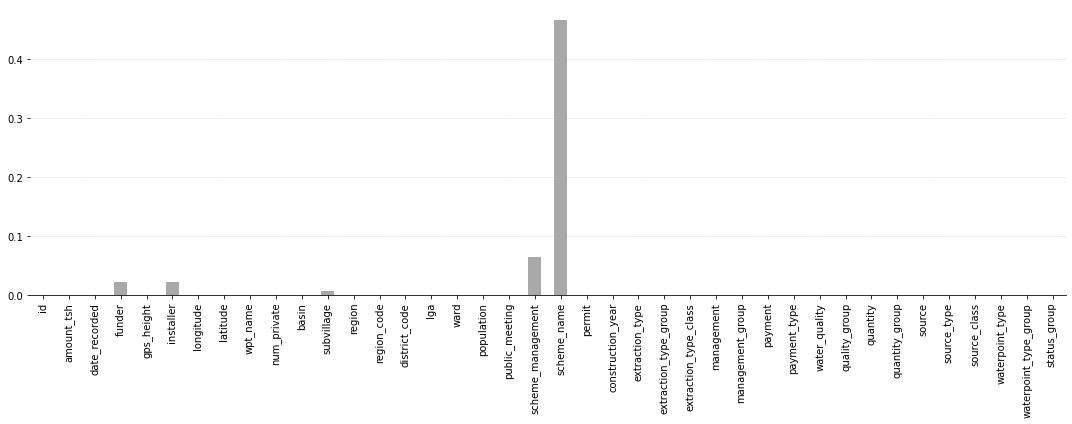

In [18]:
plt.figure(figsize = (15, 6))
df.isna().mean().plot(kind='bar', color = 'darkgray', zorder = 2)
sns.despine(left = True)
plt.grid(which = 'major', axis = 'y', color='lightgray', linestyle='--', linewidth=.5, zorder = 1)
plt.tight_layout()

In [19]:
df = df.drop(columns = 'scheme_name')
df.shape

(53281, 39)

In [20]:
# Check y values
y['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

### Modeling

Add to import cell:

```python
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
```

In [21]:
# def train_test_eval_split(X, y, random_state = None, 
#                           train_size = .6, 
#                           test_size = .2, 
#                           val_size = .2,
#                           **kwargs):
    
#     df_n_rows = X.shape[0]
    
#     train_n_rows = np.ceil(df_n_rows * train_size)
#     val_n_rows = np.ceil(df_n_rows * val_size)
#     test_n_rows = np.floor(df_n_rows * test_size)
    
#     assert train_n_rows + val_n_rows + test_n_rows == df_n_rows
    
#     X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size = train_n_rows)
#     X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size = val_n_rows)
    
#     return X_train, X_val, X_test, y_train, y_val, y_test

In [22]:
df = df.dropna(axis = 0)

In [23]:
X = df.drop(columns = ['id', 'status_group'])
y = df['status_group']

In [24]:
# train_test_eval_split(X, y)

In [25]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, train_size = .6, random_state = 0)

In [26]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = .5, random_state = 0)

In [27]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(28972, 37) (9658, 37) (9658, 37)
(28972,) (9658,) (9658,)


In [28]:
train_dataset = Pool(X_train, y_train, cat_features = X_train.select_dtypes(include = [object, 'category']).columns.tolist())

In [29]:
model_params = {
    'iterations': 1_000, 
    'loss_function': 'MultiClass', 
    'train_dir': 'crossentropy',
    'allow_writing_files': False,
    'random_seed': 42,
}

model = CatBoostClassifier(**model_params)
model.fit(train_dataset, verbose=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.093947
0:	learn: 1.0223308	total: 137ms	remaining: 2m 16s
1:	learn: 0.9643917	total: 209ms	remaining: 1m 44s
2:	learn: 0.9148655	total: 275ms	remaining: 1m 31s
3:	learn: 0.8742664	total: 347ms	remaining: 1m 26s
4:	learn: 0.8394320	total: 417ms	remaining: 1m 22s
5:	learn: 0.8114346	total: 483ms	remaining: 1m 20s
6:	learn: 0.7851697	total: 553ms	remaining: 1m 18s
7:	learn: 0.7633340	total: 618ms	remaining: 1m 16s
8:	learn: 0.7438786	total: 683ms	remaining: 1m 15s
9:	learn: 0.7270060	total: 755ms	remaining: 1m 14s
10:	learn: 0.7115701	total: 815ms	remaining: 1m 13s
11:	learn: 0.6990340	total: 883ms	remaining: 1m 12s
12:	learn: 0.6856536	total: 942ms	remaining: 1m 11s
13:	learn: 0.6749244	total: 1.01s	remaining: 1m 11s
14:	learn: 0.6643242	total: 1.07s	remaining: 1m 10s
15:	learn: 0.6549111	total: 1.14s	remaining: 1m 10s
16:	learn: 0.6460968	total: 1.21s	remaining: 1m 9s
17:	learn: 0.6378805	total: 1.26s	remaining: 1m 8s
18:	learn: 0.6300687	total: 1.32s	remaining: 1

162:	learn: 0.5068197	total: 11.4s	remaining: 58.7s
163:	learn: 0.5065029	total: 11.5s	remaining: 58.6s
164:	learn: 0.5061355	total: 11.6s	remaining: 58.6s
165:	learn: 0.5059390	total: 11.6s	remaining: 58.5s
166:	learn: 0.5056792	total: 11.7s	remaining: 58.4s
167:	learn: 0.5055999	total: 11.8s	remaining: 58.4s
168:	learn: 0.5053716	total: 11.9s	remaining: 58.3s
169:	learn: 0.5052169	total: 11.9s	remaining: 58.2s
170:	learn: 0.5051580	total: 12s	remaining: 58.2s
171:	learn: 0.5050630	total: 12.1s	remaining: 58.1s
172:	learn: 0.5048654	total: 12.2s	remaining: 58.1s
173:	learn: 0.5047763	total: 12.2s	remaining: 58s
174:	learn: 0.5047252	total: 12.3s	remaining: 58s
175:	learn: 0.5046135	total: 12.4s	remaining: 57.9s
176:	learn: 0.5041237	total: 12.4s	remaining: 57.8s
177:	learn: 0.5039323	total: 12.5s	remaining: 57.8s
178:	learn: 0.5037510	total: 12.6s	remaining: 57.7s
179:	learn: 0.5034068	total: 12.7s	remaining: 57.7s
180:	learn: 0.5031820	total: 12.7s	remaining: 57.6s
181:	learn: 0.5029

322:	learn: 0.4786370	total: 22.9s	remaining: 47.9s
323:	learn: 0.4782581	total: 22.9s	remaining: 47.8s
324:	learn: 0.4781482	total: 23s	remaining: 47.8s
325:	learn: 0.4779760	total: 23.1s	remaining: 47.7s
326:	learn: 0.4779056	total: 23.2s	remaining: 47.7s
327:	learn: 0.4776779	total: 23.2s	remaining: 47.6s
328:	learn: 0.4774954	total: 23.3s	remaining: 47.5s
329:	learn: 0.4774320	total: 23.4s	remaining: 47.5s
330:	learn: 0.4773379	total: 23.5s	remaining: 47.4s
331:	learn: 0.4771404	total: 23.5s	remaining: 47.3s
332:	learn: 0.4769494	total: 23.6s	remaining: 47.2s
333:	learn: 0.4767584	total: 23.7s	remaining: 47.2s
334:	learn: 0.4766859	total: 23.7s	remaining: 47.1s
335:	learn: 0.4766181	total: 23.8s	remaining: 47.1s
336:	learn: 0.4765754	total: 23.9s	remaining: 47s
337:	learn: 0.4763802	total: 23.9s	remaining: 46.9s
338:	learn: 0.4761821	total: 24s	remaining: 46.8s
339:	learn: 0.4760563	total: 24.1s	remaining: 46.7s
340:	learn: 0.4759465	total: 24.1s	remaining: 46.7s
341:	learn: 0.4758

482:	learn: 0.4598100	total: 34.3s	remaining: 36.7s
483:	learn: 0.4596927	total: 34.4s	remaining: 36.6s
484:	learn: 0.4596685	total: 34.4s	remaining: 36.6s
485:	learn: 0.4595193	total: 34.5s	remaining: 36.5s
486:	learn: 0.4594029	total: 34.6s	remaining: 36.4s
487:	learn: 0.4593005	total: 34.6s	remaining: 36.4s
488:	learn: 0.4591817	total: 34.7s	remaining: 36.3s
489:	learn: 0.4590746	total: 34.8s	remaining: 36.2s
490:	learn: 0.4590567	total: 34.9s	remaining: 36.1s
491:	learn: 0.4589465	total: 34.9s	remaining: 36.1s
492:	learn: 0.4588334	total: 35s	remaining: 36s
493:	learn: 0.4588008	total: 35.1s	remaining: 35.9s
494:	learn: 0.4587377	total: 35.2s	remaining: 35.9s
495:	learn: 0.4585827	total: 35.2s	remaining: 35.8s
496:	learn: 0.4584503	total: 35.3s	remaining: 35.7s
497:	learn: 0.4583462	total: 35.4s	remaining: 35.6s
498:	learn: 0.4582907	total: 35.4s	remaining: 35.6s
499:	learn: 0.4582713	total: 35.5s	remaining: 35.5s
500:	learn: 0.4582491	total: 35.6s	remaining: 35.4s
501:	learn: 0.45

643:	learn: 0.4427394	total: 45.8s	remaining: 25.3s
644:	learn: 0.4426082	total: 45.9s	remaining: 25.3s
645:	learn: 0.4425049	total: 46s	remaining: 25.2s
646:	learn: 0.4423774	total: 46s	remaining: 25.1s
647:	learn: 0.4423323	total: 46.1s	remaining: 25s
648:	learn: 0.4421963	total: 46.2s	remaining: 25s
649:	learn: 0.4420785	total: 46.3s	remaining: 24.9s
650:	learn: 0.4420160	total: 46.3s	remaining: 24.8s
651:	learn: 0.4419824	total: 46.4s	remaining: 24.8s
652:	learn: 0.4418662	total: 46.5s	remaining: 24.7s
653:	learn: 0.4417939	total: 46.5s	remaining: 24.6s
654:	learn: 0.4416806	total: 46.6s	remaining: 24.6s
655:	learn: 0.4416142	total: 46.7s	remaining: 24.5s
656:	learn: 0.4415386	total: 46.8s	remaining: 24.4s
657:	learn: 0.4414185	total: 46.8s	remaining: 24.3s
658:	learn: 0.4413181	total: 46.9s	remaining: 24.3s
659:	learn: 0.4412455	total: 47s	remaining: 24.2s
660:	learn: 0.4411443	total: 47s	remaining: 24.1s
661:	learn: 0.4409937	total: 47.1s	remaining: 24.1s
662:	learn: 0.4409771	to

804:	learn: 0.4271898	total: 57.9s	remaining: 14s
805:	learn: 0.4270338	total: 58s	remaining: 13.9s
806:	learn: 0.4269770	total: 58s	remaining: 13.9s
807:	learn: 0.4269662	total: 58.1s	remaining: 13.8s
808:	learn: 0.4269598	total: 58.2s	remaining: 13.7s
809:	learn: 0.4268529	total: 58.2s	remaining: 13.7s
810:	learn: 0.4268159	total: 58.3s	remaining: 13.6s
811:	learn: 0.4266449	total: 58.4s	remaining: 13.5s
812:	learn: 0.4266053	total: 58.5s	remaining: 13.5s
813:	learn: 0.4265351	total: 58.6s	remaining: 13.4s
814:	learn: 0.4264991	total: 58.6s	remaining: 13.3s
815:	learn: 0.4264283	total: 58.7s	remaining: 13.2s
816:	learn: 0.4263171	total: 58.8s	remaining: 13.2s
817:	learn: 0.4262206	total: 58.9s	remaining: 13.1s
818:	learn: 0.4261516	total: 58.9s	remaining: 13s
819:	learn: 0.4260766	total: 59s	remaining: 13s
820:	learn: 0.4259559	total: 59.1s	remaining: 12.9s
821:	learn: 0.4258639	total: 59.2s	remaining: 12.8s
822:	learn: 0.4258280	total: 59.3s	remaining: 12.7s
823:	learn: 0.4257592	to

965:	learn: 0.4126688	total: 1m 9s	remaining: 2.45s
966:	learn: 0.4125871	total: 1m 9s	remaining: 2.38s
967:	learn: 0.4124707	total: 1m 9s	remaining: 2.3s
968:	learn: 0.4124453	total: 1m 9s	remaining: 2.23s
969:	learn: 0.4123646	total: 1m 9s	remaining: 2.16s
970:	learn: 0.4122682	total: 1m 9s	remaining: 2.09s
971:	learn: 0.4122360	total: 1m 9s	remaining: 2.02s
972:	learn: 0.4121103	total: 1m 10s	remaining: 1.94s
973:	learn: 0.4120394	total: 1m 10s	remaining: 1.87s
974:	learn: 0.4120184	total: 1m 10s	remaining: 1.8s
975:	learn: 0.4119606	total: 1m 10s	remaining: 1.73s
976:	learn: 0.4119359	total: 1m 10s	remaining: 1.66s
977:	learn: 0.4118543	total: 1m 10s	remaining: 1.58s
978:	learn: 0.4118198	total: 1m 10s	remaining: 1.51s
979:	learn: 0.4116910	total: 1m 10s	remaining: 1.44s
980:	learn: 0.4116605	total: 1m 10s	remaining: 1.37s
981:	learn: 0.4115745	total: 1m 10s	remaining: 1.29s
982:	learn: 0.4115061	total: 1m 10s	remaining: 1.22s
983:	learn: 0.4114514	total: 1m 10s	remaining: 1.15s
98

In [30]:
y_pred_val = model.predict(X_val)

In [31]:
from sklearn.metrics import plot_confusion_matrix, classification_report

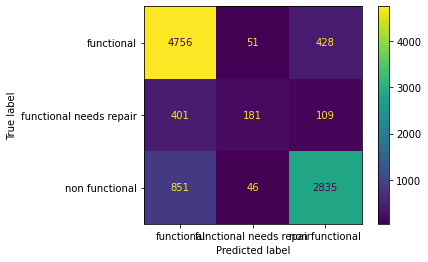

In [32]:
print(plot_confusion_matrix(model, X_val, y_val))

In [33]:
print(classification_report(y_val, y_pred_val))

                         precision    recall  f1-score   support

             functional       0.79      0.91      0.85      5235
functional needs repair       0.65      0.26      0.37       691
         non functional       0.84      0.76      0.80      3732

               accuracy                           0.80      9658
              macro avg       0.76      0.64      0.67      9658
           weighted avg       0.80      0.80      0.79      9658



### Impute missing values

```python 
### from sklearn.impute import KNNimmputer
```

Even if the amount of total rows missing is at most 3334 observations (which represents 5.6% of our dataset), I would like to try a `KNNImputer` on them.

In [ ]:
knn_imputer = KNNImputer()

In [ ]:
X[['public_meeting', 'permit']].values.astype(bool)

In [ ]:
X_knnimputer_train = X.sample(300)
index_X_knnimputer_train = X_knnimputer_train.index

y_knnimputer_train = X_knnimputer_train[['public_meeting', 'permit']]
y_permit_knnimputer_train = X_knnimputer_train['permit']

X_knnimputer_train = X_knnimputer_train.drop(columns = ['public_meeting', 'permit'])

In [ ]:
knn_imputer.fit(X_knnimputer_train, y=y_knnimputer_train)

In [ ]:
(3334 / X.shape[0]) * 100

In [ ]:
import xgboost as xgb

In [ ]:
xgb.XGBRFClassifier(use_label_encoder=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RandomForestClassifier(n_estimators=10_000)